In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, roc_auc_score, roc_curve, recall_score, confusion_matrix, classification_report
from scipy import stats
import time

%matplotlib inline

In [2]:
path = '/Users/seed/Desktop/Projects/Testin Linnear model/bank-additional-full.csv'

data = pd.read_csv(path, sep=';')

data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
data.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   4

Dataset info:

It is a dataset that describing Portugal bank marketing campaigns results.
Conducted campaigns were based mostly on direct phone calls, offering bank client to place a term deposit.
If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'

Features info:

- age: the age of the target user (between 17 and 98 ages)
- job: type of job (divided in categories) of the target user (admin, blue-collar, technician, services, management, retired, entreprenour, self-employed, housemaid, unemployed, student, unknown)
- marital: civil status of the target user (married, single, divorced, unknown)
- education: education level of the target user (university.degree, high.school, basic.9y, professional.course, basic.4y, basic.6y, unknown, illiterate )
- default: if the target user has a credit in default (yes, no or unknow)
- housing: if the target user has a housing loan (yes, no or unknow)
- loan: if the target user has a personal loan (yes or no)
- contact: telephone means to contact the user (desktop telephone or movil telephone)
- month: month in wich was contacted the target user (March to December)
- day_of_week: weekday in wich was contacted the target user (Monday to Friday)
- duration: last contact duration, in seconds, with the target user (0 to 4918 seconds)
- campaign: number of contacts performed during this campaign and for this client (1 to 56)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (0 to 999)
- previous: number of contacts performed before this campaign and for this client (0 to 7)
- poutcome: outcome of the previous marketing campaign (failure, nonexistent, success)
- emp.var.rate: employment variation rate - quarterly indicator (-3.4 to 1.4)
- cons.price.idx: consumer price index - monthly indicator (92.20 to 94.77)
- cons.conf.idx: consumer confidence index - monthly indicator (-50.80 to -26.90)
- euribor3m: euribor 3 month rate - daily indicator (0.63 to 5.04)
- nr.employed: number of employees - quarterly indicator (4963.60 to 5228.10)

Target:

- y: If the client has subscribed a term deposit (yes or no)

Observations:

- At first sight, doing the describe method, don't seem that there aren't Null values, but in some categories the are a value named as 'unknown' and this is equivalent for Nan values.
- The target feature (y) is a binary categorical feature, so perfectly fits with logistic regression wich is a binary classifier.
- The size of the dataset seems a little bit extense so we are test, with the logistic regression, stochastic gradient descent and minibatch methods in order to se the computational time saved with them respect batch gradent descent. In other hand we are going to try the regularized linear methods like ridge regression and lasso regression (If we see that there are features that don't give clearly important information to the model)

In order to manage the null values we are going to transform it to null values, not as 'unknown' 

In [4]:
data = data.replace('unknown', np.nan)

data.isna().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

Looking for the outliers

We make a describe() in order to see the max, min and the quantiles for select features with high rate of variance to find the z-scores for them.

In [5]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


The decribe method give us dispersions measures for numerical features. We are going to create a sub-set from the original with the numerical features with a high rate of variance in order to find the significative outliers. 

I think that we must take a sight to 'age', 'duration', 'campaign', 'previous' because the distance between their third and fourth quantil is significative and calculate the z-score for them.

In [6]:
data_var = data[['age', 'duration', 'campaign', 'previous']]

z = np.abs(stats.zscore(data_var))

z

array([[1.53303429, 0.01047142, 0.56592197, 0.34949428],
       [1.62899323, 0.42150051, 0.56592197, 0.34949428],
       [0.29018564, 0.12451981, 0.56592197, 0.34949428],
       ...,
       [1.53303429, 0.26722482, 0.20490853, 0.34949428],
       [0.38152696, 0.70856893, 0.56592197, 0.34949428],
       [3.26029527, 0.07438021, 0.15610492, 1.67113606]])

The array from above tell us the the z-score from all the instances and features, so now if we fix a threshold for z-score, making a mask we could identify the position of outliers in the array.

In [7]:
np.where(z > 3)

(array([   37,    75,    83, ..., 41178, 41183, 41187]),
 array([1, 1, 1, ..., 3, 0, 0]))

the first array from above is the number of row for the outlier and the second for the columns and the second tell us the row.

In [8]:
cleaned = data_var[(z < 3).all(axis=1)]

cleaned

,age,duration,campaign,previous
0,56,261,1,0
1,57,149,1,0
2,37,226,1,0
3,40,151,1,0
4,56,307,1,0
...,...,...,...,...
41181,37,281,1,0
41182,29,112,1,1
41184,46,383,1,0
41185,56,189,2,0


In [9]:
print(' data with outliers:    ', data_var.shape[0], '\n', 
     'data without outliers: ', cleaned.shape[0], '\n',
     'number of outliers:    ', data_var.shape[0] - cleaned.shape[0]
     )

 data with outliers:     41188 
 data without outliers:  38123 
 number of outliers:     3065


Now we are going to merge the data frame cleaned only for te numerical values, and merging it with the original by te indexes

In [10]:
data_cleaned = pd.merge(cleaned, data, left_index=True, right_index=True)

data_cleaned = data_cleaned.iloc[:,4:]

In [11]:
data_cleaned.head()

,age_y,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign_y,pdays,previous_y,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [12]:
data_cleaned.shape

(38123, 21)

In order to see what we are doing with nan values, let's check the correlations between the numerical features and the target and do some visualizations of the features:

In [13]:
correlations = round(data.corr(), 2)

correlations.iloc[0:19]

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.00,-0.00,0.00,-0.03,0.02,-0.00,0.00,0.13,0.01,-0.02
duration,-0.00,1.00,-0.07,-0.05,0.02,-0.03,0.01,-0.01,-0.03,-0.04
campaign,0.00,-0.07,1.00,0.05,-0.08,0.15,0.13,-0.01,0.14,0.14
pdays,-0.03,-0.05,0.05,1.00,-0.59,0.27,0.08,-0.09,0.30,0.37
previous,0.02,0.02,-0.08,-0.59,1.00,-0.42,-0.20,-0.05,-0.45,-0.50
emp.var.rate,-0.00,-0.03,0.15,0.27,-0.42,1.00,0.78,0.20,0.97,0.91
cons.price.idx,0.00,0.01,0.13,0.08,-0.20,0.78,1.00,0.06,0.69,0.52
cons.conf.idx,0.13,-0.01,-0.01,-0.09,-0.05,0.20,0.06,1.00,0.28,0.10
euribor3m,0.01,-0.03,0.14,0.30,-0.45,0.97,0.69,0.28,1.00,0.95
nr.employed,-0.02,-0.04,0.14,0.37,-0.50,0.91,0.52,0.10,0.95,1.00


Text(0.5, 1.0, &#39;Correlations between numerical features&#39;)

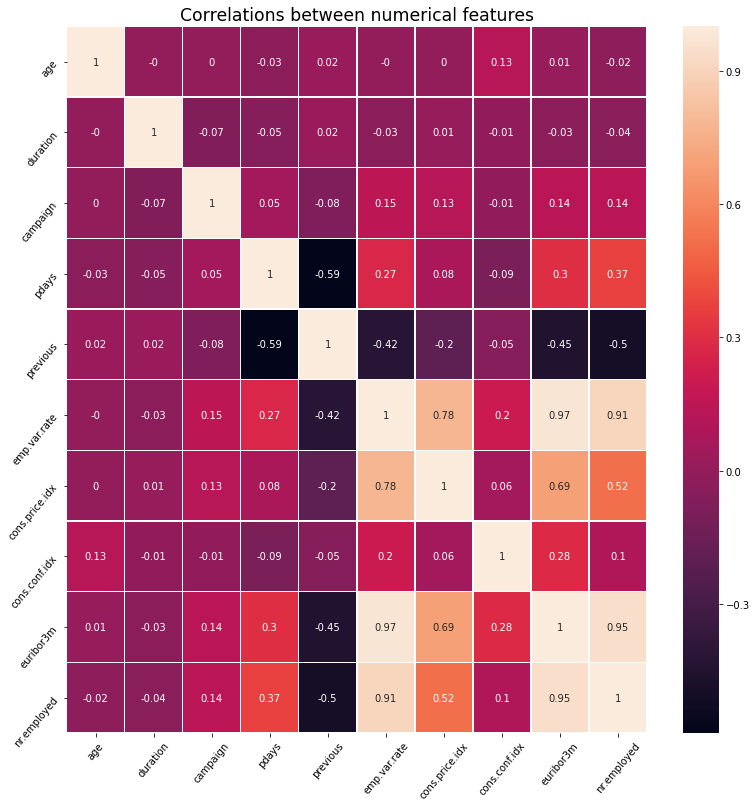

In [14]:
plt.figure(figsize=[13,13])

sns.heatmap(correlations, annot=True, linewidths=0.5)

plt.yticks(rotation=50)
plt.xticks(rotation=50)

plt.title('Correlations between numerical features', size='xx-large')

array([[&lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cef6f550&gt;,
        &lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cef91bd0&gt;,
        &lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cddf9d90&gt;],
       [&lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cde45710&gt;,
        &lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cde7bd90&gt;,
        &lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cdebe450&gt;],
       [&lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cdef3b50&gt;,
        &lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cdf37150&gt;,
        &lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cdf37190&gt;],
       [&lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cdf6d910&gt;,
        &lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9c9372890&gt;,
        &lt;matplotlib.axes._subplots.AxesSubplot object at 0x7fc9cfd2f150&gt;]],
      dtype=object)

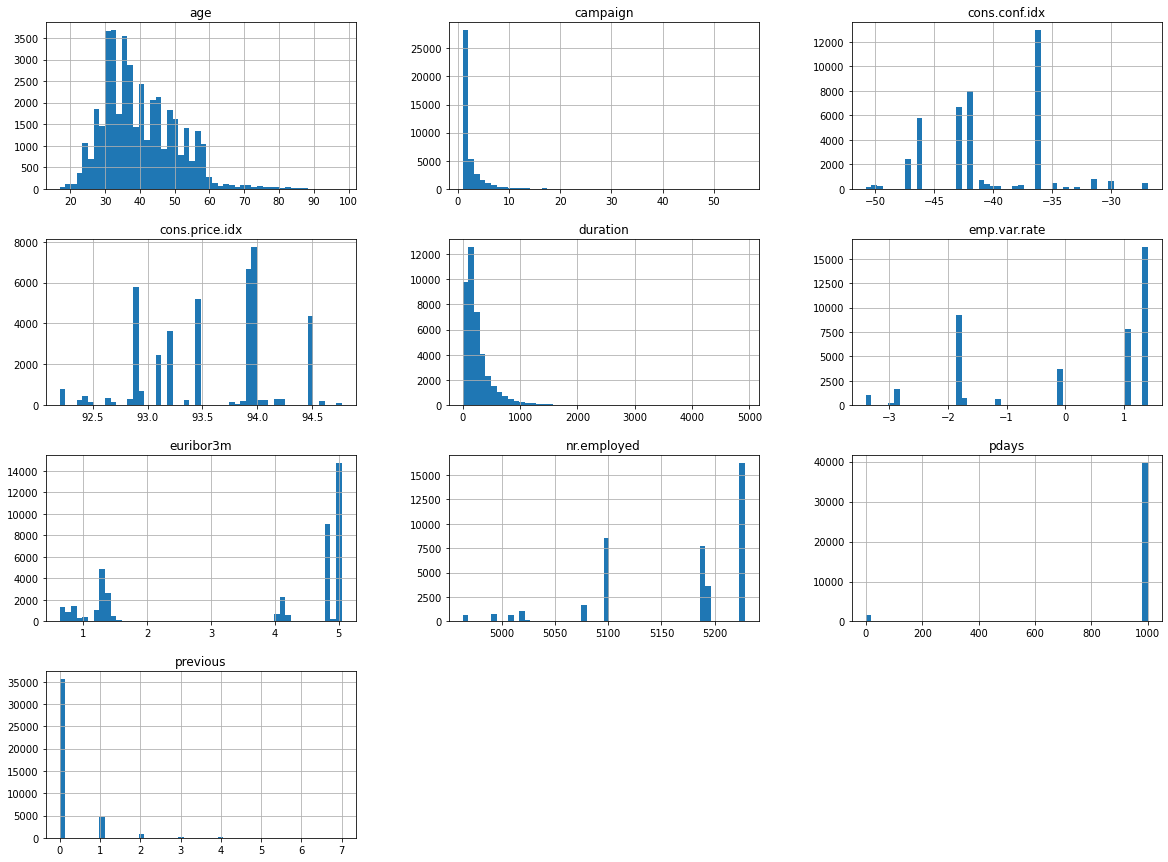

In [15]:
data.hist(bins=50, figsize=(20,15))

FEATURE ENGINEERING

In [16]:
print(' numerical data --> ', data.select_dtypes(['float', 'int']).columns, '\n'*2, 'categical data --> ', data.select_dtypes(['object']).columns)

 numerical data --&gt;  Index([&#39;age&#39;, &#39;duration&#39;, &#39;campaign&#39;, &#39;pdays&#39;, &#39;previous&#39;, &#39;emp.var.rate&#39;,
       &#39;cons.price.idx&#39;, &#39;cons.conf.idx&#39;, &#39;euribor3m&#39;, &#39;nr.employed&#39;],
      dtype=&#39;object&#39;) 

 categical data --&gt;  Index([&#39;job&#39;, &#39;marital&#39;, &#39;education&#39;, &#39;default&#39;, &#39;housing&#39;, &#39;loan&#39;, &#39;contact&#39;,
       &#39;month&#39;, &#39;day_of_week&#39;, &#39;poutcome&#39;, &#39;y&#39;],
      dtype=&#39;object&#39;)


In [17]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [18]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy is 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)

num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int')),
    ("scaler", StandardScaler())
                      ])

cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
                      ])

full_pipeline = FeatureUnion([("num_pipe", num_pipeline), ("cat_pipeline", cat_pipeline)])

data_processed = full_pipeline.fit_transform(data)

In [19]:
y = data_processed[:,-1]
X = data_processed[:,0:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now we have preprocesed the data and divided in the predictors (X) and the target (y). The main transformations of the data have been 

- The nan values for the categorical features has been changed for most the frequent value of their respective columns.
- The nan values for the numerical features has been changed for !!!!!!!!!!!!!!!!!!! (Not very sure about this)
- The numerical values have been standarized by the StandardScaler class from sklearn.

## LOGISTIC REGRESSION

In [20]:
start = time.time()

lr = LogisticRegression().fit(X_train, y_train)

elapsed_time = time.time() - start

predictions = lr.predict(X_test)

print(' Predictions =  ', predictions, '\n', 'Training time: ', elapsed_time)

 Predictions =   [0. 0. 0. ... 1. 0. 0.] 
 Training time:  0.5078530311584473


In [21]:
lr.score(X_test, y_test)

0.9075018208302986

Let's see how the model generalizes through the cross validation score:

In [22]:
cross = cross_val_score(lr, X_train, y_train, cv=5)

def mean_crossval_kfolds(x):
    avg_score = 0
    for i in x:
        avg_score += i/len(x)

    print(' Averaged score: ', avg_score, '\n', 'k-folds scores: ', x)

mean_crossval_kfolds(x=cross)

 Averaged score:  0.90649468892261 
 k-folds scores:  [0.90834598 0.90667678 0.90637329 0.90242792 0.90864947]


Let's search the best parameters with Randomizedsearch:

In [23]:
model_params = {
    'C' : [0, 0.5, 1],
    'l1_ratio': [0, 0.5, 1],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

rand = RandomizedSearchCV(lr, param_distributions=model_params, return_train_score=True, n_iter=10, iid=True).fit(X_train, y_train)

print('Best parameters: ', rand.best_params_)
print('Best estimator: ', rand.best_estimator_)

Best parameters:  {&#39;solver&#39;: &#39;saga&#39;, &#39;l1_ratio&#39;: 1, &#39;C&#39;: 1}
Best estimator:  LogisticRegression(C=1, l1_ratio=1, solver=&#39;saga&#39;)


let's see how imprive our model applying the best params suggested by RandomizedsearchCV

In [24]:
lr2 = LogisticRegression(C=0.5, l1_ratio=0, solver='lbfgs').fit(X_train, y_train)

predicts2 = lr2.predict(X_test)

lr2.score(X_test, y_test)

0.9075018208302986

In [39]:
print(classification_report(y_test, predicts2))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      7320
         1.0       0.67      0.34      0.45       918

    accuracy                           0.91      8238
   macro avg       0.79      0.66      0.70      8238
weighted avg       0.89      0.91      0.89      8238



There isn't a reliable improve for the algorythm :-(

In [25]:
cm = confusion_matrix(y_test, predictions)

cm

array([[7163,  157],
       [ 605,  313]])

In [26]:
print(' True Posituves:  ', cm[1,1],'\n',
      'True Negatives:  ', cm[0,0],'\n',
      'False Positives: ', cm[0,1],'\n',
      'False Negatives: ', cm[1,1])

 True Posituves:   313 
 True Negatives:   7163 
 False Positives:  157 
 False Negatives:  313


In [27]:
y_scores = cross_val_predict(lr2, X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

precission = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(' precission score:    ', precission,'\n',
      'recall score:        ', recall,'\n', 
      'f1 score:            ', f1,'\n',
      'True positive rate:  ', tpr,'\n', 
      'False positive rate: ', fpr,'\n',
      'Threshold:           ', thresholds)

 precission score:     0.6659574468085107 
 recall score:         0.340958605664488 
 f1 score:             0.45100864553314113 
 True positive rate:   [0.         0.36324557 1.        ] 
 False positive rate:  [0.         0.02442863 1.        ] 
 Threshold:            [2. 1. 0.]


Our classifier is balanced more to precission than recall, and for the values we can confirm the precission-recall trade off.

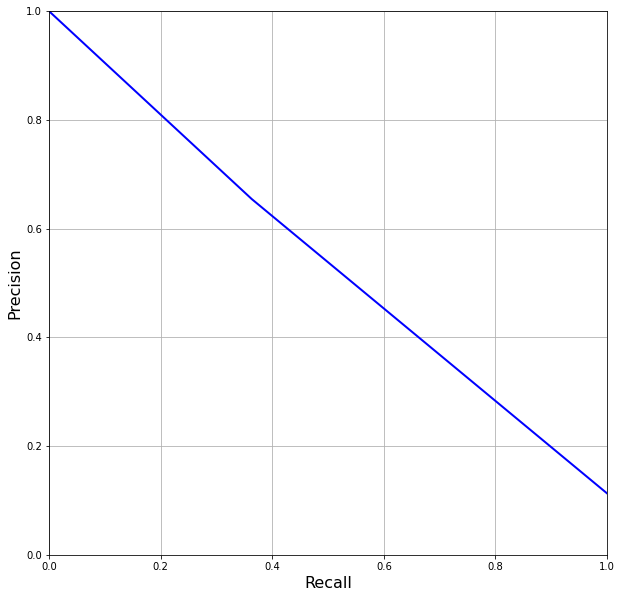

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.grid(axis='both')
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(10, 10))
plot_precision_vs_recall(precisions=precisions, recalls=recalls)

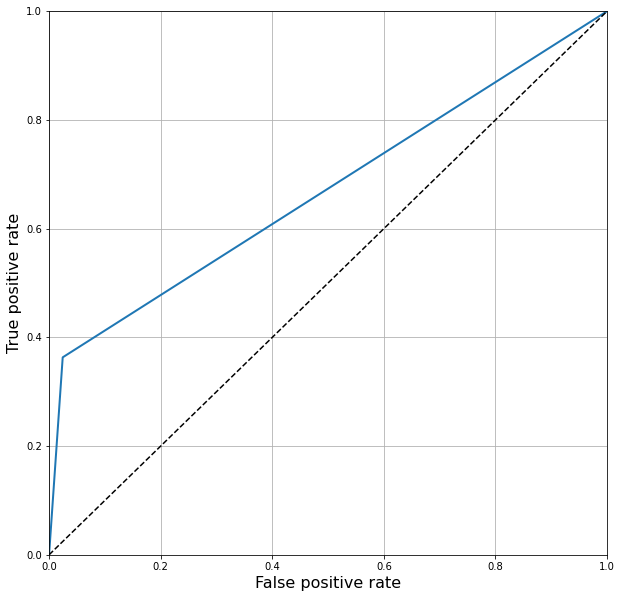

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.grid(axis='both')
    plt.ylabel('True positive rate', fontsize=16)
    plt.xlabel('False positive rate', fontsize=16)

plot_roc_curve(fpr=fpr, tpr=tpr)

## Stochastic Gradient descent classifier

When the model is trained, the way of doing predictions is very similar than the logistic regression or the other classifiers of the linear model, but with the stochastic Gradien descent the algorythm only takes one instance (The batch gradient descent uses all the instances) for claculate the gradient vector. 

We believe than we are going to have worst score (This model produces good-reasonable solutions, not optimum solutions) but let's see how many score loose the model for this small-medium dataset

In [30]:
sgd = SGDClassifier()

model_params = {
    'shuffle': [True,False],
    'loss': ['hinge', 'modified_huber', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet']
}

rand_sgd = RandomizedSearchCV(sgd, param_distributions=model_params, return_train_score=True, n_iter=10, iid=True).fit(X_train, y_train)

print('Best parameters: ', rand_sgd.best_params_)
print('Best estimator: ', rand_sgd.best_estimator_)

Best parameters:  {&#39;shuffle&#39;: False, &#39;penalty&#39;: &#39;elasticnet&#39;, &#39;loss&#39;: &#39;modified_huber&#39;}
Best estimator:  SGDClassifier(loss=&#39;modified_huber&#39;, penalty=&#39;elasticnet&#39;, shuffle=False)


In [31]:
start = time.time()

sgd = SGDClassifier(shuffle=False, penalty='l1', loss='hinge').fit(X_train, y_train)

sgd_predictions = sgd.predict(X_test)

elapsed_time = time.time() - start

print(' SGD Classifier score: ', sgd.score(X_test, y_test), '\n', 'Training time: ', elapsed_time)

 SGD Classifier score:  0.9017965525613013 
 Training time:  0.17202496528625488


In [32]:
cross_sgd = cross_val_score(sgd, X_train, y_train, cv=5)

mean_crossval_kfolds(x=cross_sgd)

 Averaged score:  0.897329286798179 
 k-folds scores:  [0.90015175 0.89939302 0.89984825 0.90015175 0.88710167]


No handles with labels found to put in legend.


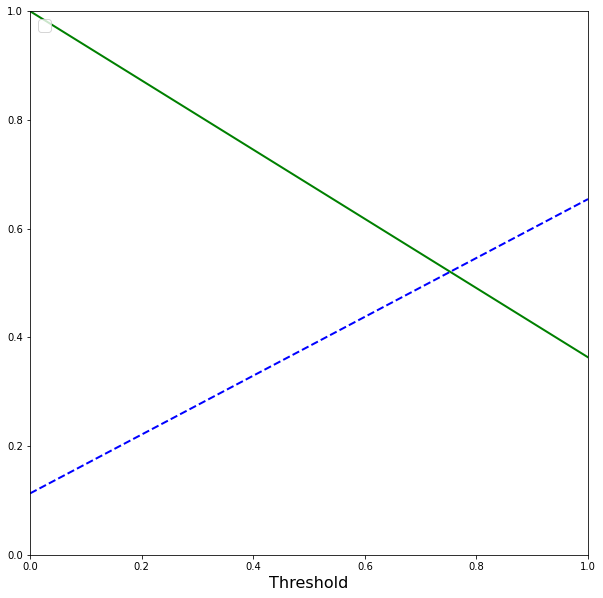

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,10))
    plt.axis([0, 1, 0, 1])
    plt.ylim([0, 1])
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)

plot_precision_recall_vs_threshold(precisions=precisions, recalls=recalls, thresholds=thresholds)

The dataset is small size so is not necessary reduce the computing time to get the train of the model, so performing stochastic gradient descent does't fit with this dataset because performs worst than batch gradient descent.